# Natural Scence Text Detection

In this projection we try to find the limitation faced by the Google Tesseract OCR in natural scene scenario. We try to overcome these problems by improving upon the detection of text on the image, then passing it onto the Tesseract OCR for text recognition.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount= True)

Mounted at /content/gdrive


In [ ]:
#import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
import pytesseract

In [ ]:
image_path = "/content/gdrive/My Drive/Sample.png"
east_path = "/content/gdrive/My Drive/frozen_east_text_detection.pb"
min_confidence_path = 0.5
height_path = 160
width_path = 288


print(image_path)
print(east_path)

/content/gdrive/My Drive/Sample.png
/content/gdrive/My Drive/frozen_east_text_detection.pb


In [ ]:
from google.colab.patches import cv2_imshow

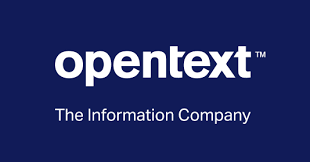

In [ ]:
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
cv2_imshow(image)

In [ ]:
#load the input image and grab the image dimensions
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
orig = image.copy()
clone1 = image.copy()
(H, W) = image.shape[:2]

#set the new width and height and then determine the ratio in change
#for both the width and height
(newW, newH) =  (width_path, height_path)
rW = W / float(newW)
rH = H / float(newH)

#resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [ ]:
#define the two output layer names for the EAST detector model that
#we are interested -- the first is the output probabilities and the
#second can be used to derive the bounding box coordinates of the text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

In [ ]:
#load the per-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(east_path)

#construct a blob from the image and then perform a forward pass of
#the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                             (123.68, 116.78, 103.94), swapRB = True, crop = False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

#show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

[INFO] loading EAST text detector...
[INFO] text detection took 0.389371 seconds


In [ ]:
print(scores)

[[[[4.1886264e-07 2.0077573e-06 4.4670364e-06 ... 3.9849210e-06
    2.1482647e-06 1.8622936e-06]
   [1.5127212e-06 3.0874807e-07 8.8943779e-07 ... 1.1859105e-06
    8.8358149e-07 1.9864074e-06]
   [1.8531165e-06 2.1944189e-07 5.7804579e-07 ... 5.0592353e-06
    4.1775243e-07 2.2956192e-06]
   ...
   [3.7756197e-06 8.5369828e-07 1.0605676e-06 ... 3.7629914e-07
    7.0215087e-08 6.9183540e-07]
   [1.4936751e-06 8.1154485e-07 4.5102658e-07 ... 2.8961193e-07
    2.5181413e-07 1.3859288e-06]
   [1.9993940e-06 9.8599052e-08 7.3061869e-08 ... 7.7292361e-07
    2.9067667e-07 2.8661855e-08]]]]


In [ ]:
#grab the number of rows and columns from the scores volume, then
#initialize our set of bounding box rectangles and corresponding
#confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

#loop over the number of rows
for y in range(0, numRows):
  #extract the scores (probabilities), followed by the geometrical
  #data used to derive potential bounding box coordinated that
  #surround text
  scoresData = scores[0, 0, y]
  xData0 = geometry[0, 0, y]
  xData1 = geometry[0, 1, y]
  xData2 = geometry[0, 2, y]
  xData3 = geometry[0, 3, y]
  anglesData = geometry[0, 4, y]
  
  count = 0
  #loop over the number of colums
  for x in range(0, numCols):
    #if score does not have sufficient probability, ignore it
    if scoresData[x] < 0.5:
      continue
    
    #compute the offset factor as our resulting features maps will 
    #be 4x smaller than the input image
    (offsetX, offsetY) = (x * 4.0, y * 4.0)

    #extract the rotation angle for the prediction and then
    #compute the sine and cosine
    angle = anglesData[x]
    cos = np.cos(angle)
    sin = np.sin(angle)

    #use the geometry volume to derive the width and height of the bounding box
    h = xData0[x] + xData2[x]
    w = xData1[x] + xData3[x]

    #compute both the starting and ending (x, y)-coordinates for
    #the text prediction bounding box
    endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
    endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
    startX = int(endX - w)
    startY = int(endY - h)

    #add the boundig box coordinates and probability score to 
    #our respetive lists
    rects.append((startX, startY, endX, endY))
    confidences.append(scoresData[x])

In [ ]:
print(rects)
print(confidences)

[(48, 33, 251, 79), (46, 33, 251, 79), (46, 32, 250, 77), (47, 33, 243, 78), (47, 34, 242, 79), (45, 36, 241, 81), (46, 36, 240, 82), (45, 36, 241, 81), (44, 37, 237, 82), (46, 36, 241, 81), (48, 37, 244, 81), (49, 36, 243, 82), (50, 39, 241, 84), (51, 37, 240, 82), (53, 36, 241, 81), (53, 37, 239, 81), (53, 38, 237, 83), (53, 37, 239, 82), (49, 37, 239, 82), (54, 38, 241, 82), (53, 38, 239, 82), (50, 38, 239, 82), (51, 38, 242, 82), (52, 37, 243, 81), (52, 37, 244, 82), (52, 38, 242, 83), (47, 38, 244, 84), (45, 38, 243, 84), (47, 37, 244, 84), (53, 38, 242, 84), (51, 37, 242, 83), (53, 37, 241, 83), (53, 37, 240, 83), (50, 37, 240, 82), (46, 38, 240, 83), (48, 38, 239, 83), (49, 38, 239, 83), (49, 38, 237, 83), (48, 39, 236, 82), (53, 40, 236, 81), (48, 33, 249, 79), (47, 34, 245, 80), (47, 36, 246, 81), (48, 36, 242, 80), (48, 37, 241, 80), (46, 38, 238, 83), (44, 40, 239, 84), (45, 39, 237, 83), (44, 39, 237, 82), (45, 39, 243, 82), (48, 41, 241, 83), (49, 40, 241, 83), (49, 39, 24

[[ 84 103 161 118]
 [ 48  39 236  81]
 [167 104 234 123]
 [ 49 105  79 121]]


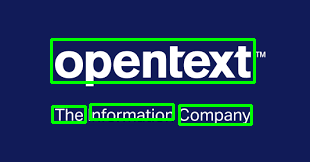

[[104, 119, 90, 173], [39, 82, 51, 254], [105, 124, 179, 251], [106, 122, 52, 85]]


In [ ]:
#apply non_max_suppresion to supress weak, overlapping bounding boxes
boxes = non_max_suppression(np.array(rects), probs = confidences)
print(boxes)
roi = []
#loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
  #scale the bounding box coordinates based on the respective ratios
  startX = int(startX * rW)
  startY = int(startY * rH)
  endX = int(endX * rW)
  endY = int(endY * rH)

  #draw the bounding box on the image
  cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255 , 0), 2)
  roi.append([startY, endY, startX, endX])

#show the output image
cv2_imshow(orig)
cv2.waitKey(0)

print(roi)

[104, 119, 90, 173]
er



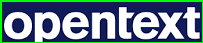

[39, 82, 51, 254]
opentext



[105, 124, 179, 251]
Company



[106, 122, 52, 85]
The



In [ ]:
for i in roi:
  temp = orig[i[0]:i[1], i[2]:i[3]]
  cv2_imshow(temp)
  print(i)
  cus_config = r'--oem 3 --psm 6'
  text = pytesseract.image_to_string(temp, config= cus_config)
  print(text)

<h1> Comparsion with Unsegmented Tesseract OCR

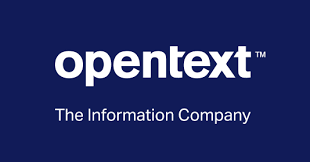

opentext”
SiMe keel



In [ ]:
cus_config = r'--oem 3 --psm 6'
newImg = clone1.copy()
text = pytesseract.image_to_string(newImg, config= cus_config)
cv2_imshow(newImg)
print(text)

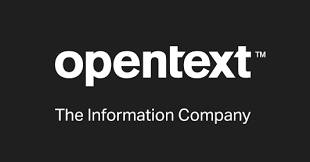

opentext”
TM keenT



In [ ]:
#Converting to grey scale
cus_config = r'--oem 3 --psm 6'
newImg = cv2.cvtColor(clone1, cv2.COLOR_BGR2GRAY)
text = pytesseract.image_to_string(newImg, config= cus_config)
cv2_imshow(newImg)
print(text)

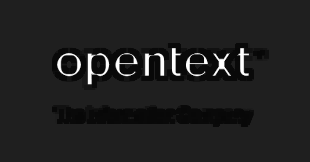

opentext



In [ ]:
cus_config = r'--oem 3 --psm 6'

#Converting to greyscale
newImg = cv2.cvtColor(clone1, cv2.COLOR_BGR2GRAY)

#Thresholding
threshImg = cv2.threshold(newImg, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#Eroding
kernel = np.ones((5,5),np.uint8)
eroImg = cv2.erode(newImg, kernel, iterations = 1)

text = pytesseract.image_to_string(eroImg, config= cus_config)

cv2_imshow(eroImg)
print(text)

In [ ]:
r'--oem 3 --psm 6'

("-l eng --oen 2 --pam 12")

'-l eng --oen 2 --pam 12'